<a href="https://colab.research.google.com/github/Matteo-Candi/ADM_HW2/blob/Matteo/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2 - ADM - group 17**

Description

In [61]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
locations = pd.read_csv('/content/drive/MyDrive/ADM/instagram_locations.csv', sep='\t')

In [ ]:
profiles = pd.read_csv('/content/drive/MyDrive/ADM/instagram_profiles.csv', sep='\t')

In [ ]:
posts = pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t')



--------------------------------------------------------------------------------

# Research Questions

## RQ1

## RQ2

Plot the number of posts for each profile in descending order

count    3452771.00
mean         409.54
std         1041.94
min            0.00
25%           22.00
50%          120.00
75%          420.00
max       183730.00
Name: n_posts, dtype: float64 

There are: 1056815 NaN values


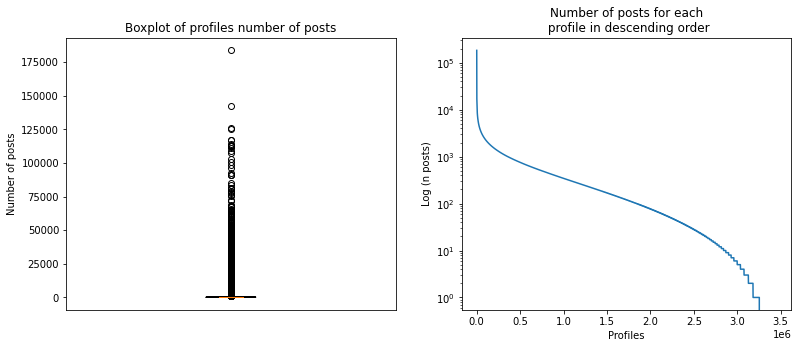

In [ ]:
print(round(profiles.n_posts.describe(),2), '\n')   # Returning the statistics it does not consider NaN values
print(f'There are: {profiles.n_posts.isna().sum()} NaN values')
n_posts = profiles.n_posts.dropna()
fig, axs = plt.subplots(1,2)
fig.set_size_inches(13, 5)

axs[0].boxplot(np.array(n_posts), 'b')
axs[0].set_xticks([])
axs[0].set(title='Boxplot of profiles number of posts', ylabel='Number of posts')

axs[1].plot(np.sort(n_posts)[::-1])
axs[1].set_title('Number of posts for each\n profile in descending order')
axs[1].set(ylabel='Log (n posts)', xlabel='Profiles', yscale='log')

plt.show()

What posts have the highest number of "likes"?

In [ ]:
most_likes = pd.DataFrame(columns=['post_id', 'numbr_likes'])

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'numbr_likes']):
    chunk_most_like = chunk.sort_values(by='numbr_likes', ascending=False).head(5)
    most_likes = pd.concat([most_likes, chunk_most_like])

# To get all the rows we have to get one piece a time because the ram is not enough.
# After sorting this chunck we append the highest values of our variable in another dataframe
# with all the highest values. Than we return the highest of the highest.

most_likes.sort_values(by='numbr_likes', ascending=False).head(5)

,post_id,numbr_likes
19624085,Bt3yaXmAM0d,8822952.0
19623988,BuwffB7g8cK,5447066.0
19624082,Buc1gyZAaMQ,5116398.0
19623986,BvcukE8AMuG,4271466.0
39701024,BqSLFVBFLfq,4264745


What posts have the most and the least number of comments?

In [ ]:
most_comment = pd.DataFrame(columns=['post_id', 'number_comments'])
least_comment = pd.DataFrame(columns=['post_id', 'number_comments'])

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'number_comments']):
    chunk_most = chunk.sort_values(by='number_comments', ascending=False).head(5)
    chunk_least = chunk.sort_values(by='number_comments', ascending=False).tail(5)
    most_comment = pd.concat([most_comment, chunk_most])
    least_comment = pd.concat([least_comment, chunk_least])
  
print('Posts with most comments\n\n', most_comment.sort_values(by='number_comments', ascending=False).head(5))
print('\n\nPosts with least comments\n\n', least_comment.sort_values(by='number_comments', ascending=False).head(5))


# We take all the dataset by chunk and for every chunk, after ordering it, we take the first and the last five.
# In the end we take the highest among the highest and the lowest among the lowest.

Posts with most comments

               post_id number_comments
41873060  Bx2sPAjHviO          488953
12164781  BuGjhWAhAW5          313997
33261751  BJ-rkpTgn1N          257488
11149127  BMtisIxjhtT          214365
9383817   BzOOWj3DfZK          189888


Posts with least comments

               post_id number_comments
77497     BxhcazrhJVo               0
29752487  BwiS3P2h_sm               0
29752484  BwwhHRUganM               0
29499999  Bw4F7e-A3PB               0
29374405  BxWHjO0ntUC               0


Since the least number of comments in a post is 0, there are a lot posts with this value. Also checking the posts with 1 or 2 comments would be useless because for sure there are a lot. Differently the posts most comented are more interesting and show us the boarderline cases like the first that have almost 500k comments.


How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.

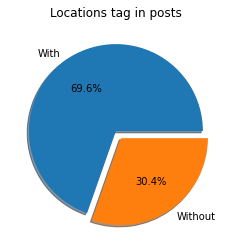

In [ ]:
loc = 0
no_loc = 0

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'location_id']):
    no_loc += chunk.location_id.isna().sum()
    loc += len(chunk)

loc = loc - no_loc

plt.pie([loc, no_loc], labels=['With', 'Without'], shadow=True, explode=(0, .1),autopct='%1.1f%%')
plt.title('Locations tag in posts')
plt.show()

How many posts include only photos? How many also have videos?

In [ ]:
n_photos = 0
n_multy = 0

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'post_type']):
    for el in chunk.post_type:
        if el == 1:
            n_photos +=1
        elif el == 3:
            n_multy += 1

print(f'There are {n_photos} posts that include only photos.')
print(f'There are {n_multy} posts that include also videos.')

There are 41534486 posts that include only photos.
There are 40943 posts that include also videos.


What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

Proportion of NA in business_account variable: 0.24




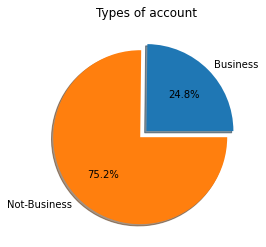

In [ ]:
print(f"Proportion of NA in business_account variable: {round(profiles.is_business_account.isna().sum() / len(profiles.is_business_account), 2)}\n\n")
business = profiles.is_business_account.dropna()
t = sum(business)
f = len(business) - t

plt.pie([t,f], labels=['Business', 'Not-Business'], shadow=True, explode=(0, .1),autopct='%1.1f%%')
plt.title('Types of account')
plt.show()

## RQ3

## RQ4

## RQ5

## RQ6

## RQ7

What's the probability that a post receives more than 20% "likes" of the number of followers a user has?

In [ ]:
profiles = pd.read_csv('/content/drive/MyDrive/ADM/instagram_profiles.csv', sep='\t', usecols=['sid', 'followers'])
profiles = profiles.dropna()

all = 0
tot = 0
for chunk in tqdm(pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['sid_profile', 'numbr_likes'])):
    data = pd.merge(chunk, profiles, left_on='sid_profile', right_on='sid').drop('sid', axis=1)
    all += (data.apply(lambda x: x.numbr_likes/ x.followers, axis=1) > 0.2).sum()
    tot += len(chunk)

print(f"The probability is: {round(all/tot, 3)*100}%")

Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not.

In [86]:
profiles = pd.read_csv('/content/drive/MyDrive/ADM/instagram_profiles.csv', sep='\t', usecols=['sid'])
profiles = list(profiles.sid)
prof_dict = {k: [] for k in profiles}       # creating a dictionary with all profiles

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['sid_profile', 'location_id']):
    chunk = chunk[chunk.sid_profile != -1].dropna()     # cleaning the chunk
    for loc, prof in zip(chunk.location_id, chunk.sid_profile):
        prof_dict[int(prof)].append(loc)            # appending to profiles any locations they visited

count = 0
tot = 0
for item in prof_dict.values():         # counting for every profiles how many times they visited every location where they posted
    d = Counter(item)
    v = [i for i in d.values() if i > 1]        
    count += len(v)                     # counting only the location where they ahve been more than once
    tot += len(set(item))

print(f"The probability is: {round(count/tot, 3)*100}%")

The probability is: 18.8%


We compute this  probability supposing that a user posts a post only when he goes in a location. So of course this result can not have sense because a user could also posts something with the same location of the previous posts having taken a picture in the same moment of the previous. So posting a post with a location that is the same of some previous one not imply that the user is back in the same place and so this probability doesn't have any sense.

## RQ8

Does more “likes” also mean more comments? Plot a scatter plot of “likes” vs comments for posts.

Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice.

What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures.

In [ ]:
profiles = pd.read_csv('/content/drive/MyDrive/ADM/instagram_profiles.csv', sep='\t', usecols=['sid', 'followers'])

In [ ]:
followers = np.array(profiles.followers)
followers = followers[~np.isnan(followers)]
followers.mean()
rng = np.arange(10,91,10)
quant = np.percentile(followers,rng)
data = {'Quantile': rng, 'Value': quant}
pd.DataFrame(data)


,Quantile,Value
0,10,60.0
1,20,124.0
2,30,198.0
3,40,289.0
4,50,406.0
5,60,563.0
6,70,804.0
7,80,1191.0
8,90,2502.0


What are histograms, bar plots, scatterplots and pie charts used for?

What insights can you extract from a Box Plot?

## Bonus Points

--------------------------------------------------------------------------------

# Command Line Question

--------------------------------------------------------------------------------

# Algorithmic Question

## AQ1

In [ ]:
ciao

## AQ2